# 주택 가격 예측 : 회귀 

1. 분류 : 입력 데이터 포인트의 개별적인 레이블 하나를 예측하는 게 목적

2. 회귀 : 개별적인 레이블 대신 연속적인 값을 예측 
    - ex) 기상 데이터가 주어졌을 때 내일 기온 예측
    - ex) 소프트웨어 명세서가 주어졌을 때 프로젝트가 완료될 시간 예측 
    
※로지스틱 회귀 : 회귀 알고리즘이 아니라 분류 알고리즘이다.

### 데이터 로드

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = \
boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 1s 10us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [6]:
train_targets[:5] #주택의 중간 가격. 천 달러 단위

array([15.2, 42.3, 50. , 21.1, 17.7])

### 데이터 준비 

이 데이터들은 상이한 스케일을 갖고 있다.

어떤 값은 0과 1사이의 비율을 나타내며, 어떤 것은 1과 12 사이의 값, 또 어떤 값을 1과 100 사이의 값을 가진다. 이대로 신경망에 주입하면 문제가 된다. (특성의 스케일이 다르면 전역 최소 점을 찾아가는 경사 하강법의 경로가 스케일이 큰 특성에 영향을 많이 받는다) 

따라서 해법은 **특성 별로 표준화**하는 것이다. 
입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해 **특성의 평균을 빼고 표준 편차로 나눈다**. 특성의 중앙이 0 근처에 맞추어지고 표준 편차는 1이 된다. 

### 데이터 정규화(표준화)하기

※주의 : 테스트 데이터는 오직 예측에만 쓸 것. 아래에서도 훈련 데이터만으로 표준화했다. 

훈련 데이터와 테스트 데이터를 각각 다른 스케일로 변환하면 훈련 데이터에서 학습한 정보가 쓸모 없어지게 된다. 마찬가지로 실전에 투입하여 **새로운 데이터에 대한 예측을 만들 때도, 훈련 데이터에서 계산한 값을 사용해 표준화**해야 한다.

In [8]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### 모델 구성

샘플 개수가 적으므로 64개 유닛을 가진 2개의 은닉 층으로 작은 네트워크 구성. 훈련 데이터의 개수가 적을 수록 오버피팅이 쉽게 일어나므로 작은 모델을 사용해야 한다.

In [11]:
from keras import models
from keras import layers

def build_model() : # 동일 모델을 여러 번 생성할 것이므로 함수를 만들어 사용
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

`model.add(layers.Dense(1))` : 하나의 유닛. 그리고 활성화 함수가 없다.

이런 층을 '선형 층'이라고 한다. 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀) 구성이다. 활성화 함수를 적용하면 출력 값의 범위를 제한한다. 여기서는 마지막 층이 순수한 선형이므로 네트워크는 어떤 범위 값이라도 예측하도록 자유롭게 학습한다.

`model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])` : 
mse 손실 함수는 평균 제곱 오차(meas squared error)의 약어로 예측과 타깃 사이 거리의 제곱이다. 회귀 문제에서 널리 사용되는 손실 함수이다. 

평균 절대 오차(Mean Absolute Error, mae)를 측정한다. 예측과 타깃 사이 거리의 절댓값이다. ex) 이 예제에서 mae가 0.5면 예측이 평균적으로 500달러 정도 차이가 난다.

### K-겹 검증을 사용한 훈련 검증

이렇게 샘플이 적은 데이터에서는 검증 세트를 나눌 때 어떤 데이터 포인트들이 선택되었는지에 따라 검증 점수가 크게 달라진다. 따라서 **K-겹 교차 검증**을 사용한다. 

데이터를 K개의 '분할(fold, 폴드)'로 나누고(일반적으로 4, 5개) K개 모델을 각각 만들어 k-1개 분할에서 훈련하고 나머지 분할에서 평가하는 방법. 

모델의 검증 점수는 k개 검증 점수를 평균낸 것이다.

![k겹 검증](images/k.png "k")

In [19]:
import numpy as np 

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k) :
    print('처리 중인 폴드#', i)
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

    partial_train_data = np.concatenate( #훈련 데이터 준비 : 다른 분할 전체
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis=0)

    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0)

    model = build_model() #케라스 모델 구성(컴파일 포함)

    #모델 훈련(verbose=0이므로 훈련 과정이 출력되지는 않는다.)
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)

    #var_targets : 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리 중인 폴드# 0
처리 중인 폴드# 1
처리 중인 폴드# 2
처리 중인 폴드# 3


In [20]:
all_scores

[2.1856382436091355, 2.3448428706367417, 2.5057740187881015, 2.47945762742864]

In [21]:
np.mean(all_scores)

2.3789281901156545

In [22]:
num_epochs = 500
all_mae_histories = []

for i in range(k) :
    print('처리 중인 폴드#', i)
    #k번째 폴드 : 검증 데이터 준비
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples] 
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

    partial_train_data = np.concatenate( #훈련 데이터 준비 : 다른 폴드 전체
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis=0)

    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0)

    model = build_model() #케라스 모델 구성(컴파일 포함)

    #모델 훈련(verbose=0이므로 훈련 과정이 출력되지는 않는다.)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리 중인 폴드# 0
처리 중인 폴드# 1
처리 중인 폴드# 2
처리 중인 폴드# 3


### K-겹 검증 점수 평균 기록하기 

In [23]:
avg_mae_history = [
    np.mean([ x[i] for x in all_mae_histories ]) for i in range(num_epochs) ]


### 검증 점수 그래프 

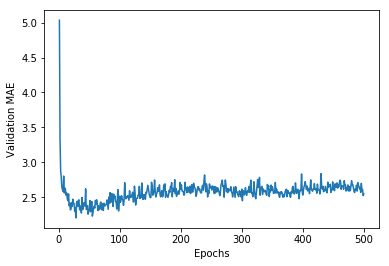

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(avg_mae_history) + 1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기 

1. 곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 데이터 포인트를 제외

2. 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균(exponential moving average)로 대체한다. 

※지수 이동 평균 : 시계열 데이터를 부드럽게 만드는 기법 중 하나이다. 아래 코드에서 계산된 이동 평균에 factor를 곱하고 현재 포인트에 (1 - factor)를 곱해 합산한 것을 가리킨다.

In [25]:
def smooth_curve(points, factor=0.9) :
    smoothed_points = []
    
    for point in points : 
        if smoothed_points :
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
            
        else : 
            smoothed_points.append(point)
        
    return smoothed_points

In [26]:
smoothed_mae_history = smooth_curve(avg_mae_history[10:])

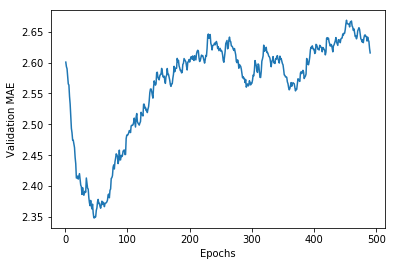

In [29]:
plt.plot(range(1, len(smoothed_mae_history) + 1), smoothed_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

모델의 여러 매개변수에 대한 튜닝이 끝나면(에포크 수뿐 아니라 은닉 층 크기도 조절 가능하다) 모든 훈련 데이터를 사용하고 최상의 매개변수로 최종 실전에 투입될 모델을 훈련한다. 그 뒤, 테스트 데이터로 성능을 확인한다.

### 최종 모델 훈련하기 

In [31]:
model = build_model() #새롭게 컴파일 된 모델을 얻는다.
model.fit(train_data, train_targets, #전체 데이터로 훈련시킨다.
         epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


In [34]:
test_mae_score

45.15549543792126

# 정리


1. 회귀는 분류에서 사용했던 것과는 다른 손실 함수를 사용한다. MSE

2. 회귀에서 사용되는 평가 지표는 분류와 다르다. 정확도 개념은 회귀에 적용되지 않는다. 일반적인 회귀 지표는 평균 절대 오차 MAE이다.

3. 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 개별적으로 스케일을 조정해야 한다.

4. 가용 데이터가 적다면 k-겹 검증을 사용하는 것이 신뢰할 수 있는 모델 평가 방법이다. 

5. 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉 층의 수를 줄인다.(일반적으로 1개 또는 2개)